# Teach Your Laptop to Trade Stock Options. 
What could possibly go wrong?

05/01/2020

Rich Comments
1. Note the run-time warning.
2. Show an overview (the 3 tell 'ems). Use collapsing, expanding sets of blocks.
3. Code Style - Pythonic? Rewrite code to use best practices.
4. Print only new columns or changed data,, not then entire df.
5. State Purpose of this notebook - To build a feature set for stock option trading.
5. Visualizations - 

## Purpose - Build a Feature Set from Stock Prices
This notebook is the first in a series of four notebooks that illustrates how to develop a Machine Learner to trade stock options. This notebook will demonstrate how to create a set of features from a a sequential time series of stock prices. The code snippets shown apply to any sequential data sets. 

## Contents
1. Create Features from time-series stock price data.
2. Review Features from Option Transaction Data.
3. Merge the Feature Sets. Avoid Future Leakage!

 - What You Need: Basic knowledge of Python, pandas, numpy, dataframes, and statistics.

 - What You Don't Need: Knowledge of linear algebra, calculus, or Machine Learning. The Python libraries, particularly scipy for ML, do all the heavy lifting.
 
You Will Learn:
 - How to manipulate time-series df columns using pandas column vector operations.
 - How to manipulate datetime columns to synchronize data columns and dataframes.
 - How to join dataframes along datetime columns.  

### 1. Create Features from Stock Price Data.

Since we will be trading only stock options on ExxonMobil (ticker XOM) we will limit our features to elements connected with XOM stock and XOM options transactions. First, let's download stock data for XOM for the time period 04/01/2017 - 05/01/2018. Yahoo Finance provides this data in csv format, as do many other finance websites. 

The source file is named 'XOMOHLC 2016-2018.csv' Read the data into a dataframe and inspect the first few rows with the .head() instruction. Don't forget to import the necessary libraries.

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

input_file_name    = 'XOMOHLC 2016-2018.csv'
stock_OHLC_data      = pd.read_csv(input_file_name, index_col = False)
print(stock_OHLC_data.head(5))
print(stock_OHLC_data.tail(5))


         Date       Open       High        Low      Close  Adj Close    Volume
0  2016-03-28  84.029999  84.360001  83.699997  84.220001  71.432426   7490400
1  2016-03-29  83.669998  84.610001  83.160004  84.529999  71.695351   9977900
2  2016-03-30  85.029999  85.050003  84.000000  84.519997  71.686890  10807000
3  2016-03-31  84.070000  85.099998  83.589996  83.589996  70.898094  13896900
4  2016-04-01  82.400002  83.389999  82.389999  82.959999  70.363739  12235300
           Date       Open       High        Low      Close  Adj Close  \
542  2018-05-21  81.730003  82.349998  81.519997  82.279999  75.848869   
543  2018-05-22  82.440002  82.650002  81.349998  81.639999  75.258888   
544  2018-05-23  80.949997  82.230003  80.570000  82.150002  75.729027   
545  2018-05-24  81.349998  81.360001  79.949997  80.269997  73.995972   
546  2018-05-25  79.279999  79.330002  78.089996  78.709999  72.557899   

       Volume  
542   8822400  
543  10753400  
544  15140900  
545  13360500  
5

Walls of numbers, as shown above from the head and tail functions, are great for computers, but inconvenient for humans, who understand much better through pictures and charts. The next code snippet is a function to display several number series in a chart format. It uses MatPlotLib, then standard charting tool for Python.

Questions:
 - The variable 'density' is passed to the function, but currently not used. 
 - What should it do to the data set?
 - Write the code that implements the density reduction.
 - How does it change the chart? Does it improve the viewer's understanding? Why or not?

module://ipykernel.pylab.backend_inline


<ipython-input-12-3d0b41da2fdb>:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


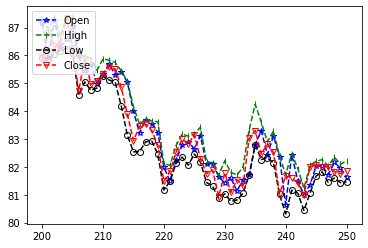

In [12]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('module://ipykernel.pylab.backend_inline')

print(matplotlib.get_backend())

def Chart_Multi_Plot(features, cols, density, min_row, max_row):
    # density currently not implemented. For dense plots, it reduces the number of plot points by 1 / density.

    fig=plt.figure()
    fig.show()
    
    ax=fig.add_subplot(111)

    color_list  = ['b', 'g', 'k', 'r', 'm']
    marker_list = ['*', '|', 'o', 'v', 'x']
    line_style  = ['none']
    line_style  = ['--', '-', ':', '+', '.']

    features = features.loc[min_row : max_row]
    
    for i in range(len(cols)):
        ax.plot(features.index,features[cols[i]].values,c=color_list[i], marker=marker_list[i], ls=line_style[0], \
                label=cols[i], fillstyle='none')
    plt.legend(loc=2)
    plt.draw()

plot_cols = ['Open', 'High', 'Low', 'Close']

freq = 10  #freq reduces plot point density. Density = total points / freq
min_row = 200
max_row = 250

Chart_Multi_Plot(stock_OHLC_data, plot_cols, freq, min_row, max_row)


Since we are trading short-term optons, we suspect more recent stock prices have a much higher value for predicting the profitability of an option trade. Therefore we will limit our features to stock prices for the past 45 days, with two exceptions, which we will review later. After completing the entire project, then we may choose to test different feature sets to improve the learning, and get better overall trading results.

With historical OHLCV data loaded into our stock_OHLC_data df, we are ready to create some features. Stock forecasters use many combinations of stock prices to develop forecasts. Because we want the Machine Learner (Learner) to use its own methods to predict good options, we don't want to pre-process the stock data too much. So we will pick only three combinations of stock prices.

1. Closing stock price for the five trading days prior to the option day.
2. Simple Moving Averages (SMAs) of stock prices for these date ranges: 45, 30, 15, and 10 days prior to the option day.
3.  Stock Price Velocity (rate of change) for these date ranges: 45, 30, 15, 10, 5, and 2 days prior to the option day.

There are many other combinations of stock prices and date ranges. In later exercises we can test this feature set against other feature sets, and even use feature reduction to identify stock price features with the highest predictive value, after we get started with the first feature set. 

First, let's get closing stock prices for the previous five trading days. Some questions:

Questions:
 - Why the .copy() suffix on stock_OHLC_data?
 - How many columns does this loop create?
 - What is the name of each column?
 - Why the Nans in the 'days old' columns?
 - What date is the 'days old' relative to? How?

In [3]:
previous_days = 5

stock_price_features = stock_OHLC_data.copy()
for prev_day in range(1,(previous_days+1)):
   stock_price_features[str(prev_day) + ' days old'] = stock_price_features['Close'].shift(prev_day)

print(stock_price_features.head(5))

         Date       Open       High        Low      Close  Adj Close  \
0  2016-03-28  84.029999  84.360001  83.699997  84.220001  71.432426   
1  2016-03-29  83.669998  84.610001  83.160004  84.529999  71.695351   
2  2016-03-30  85.029999  85.050003  84.000000  84.519997  71.686890   
3  2016-03-31  84.070000  85.099998  83.589996  83.589996  70.898094   
4  2016-04-01  82.400002  83.389999  82.389999  82.959999  70.363739   

     Volume  1 days old  2 days old  3 days old  4 days old  5 days old  
0   7490400         NaN         NaN         NaN         NaN         NaN  
1   9977900   84.220001         NaN         NaN         NaN         NaN  
2  10807000   84.529999   84.220001         NaN         NaN         NaN  
3  13896900   84.519997   84.529999   84.220001         NaN         NaN  
4  12235300   83.589996   84.519997   84.529999   84.220001         NaN  


Second, let's create feature columns with simple moving averages (SMAs).

Questions:
 - How did we create the column names? 
 - Can you invent another way to create collumn names?
 - What tdo the two functions .rolling and .mean do?
 - If you switch the order of the suffixes, what happens?
 - What about those NaNs? What determines how many NaNs in each SMA column?
 - Why use NaN instead of 0.0, or just a plain blank?

In [4]:
SMA_periods = [45, 30, 15, 10]

for days in SMA_periods:
   SMA_col_label = str(days) + ' day SMA'
   stock_price_features[SMA_col_label] = stock_price_features['Close'].rolling(window = days).mean()

print(stock_price_features.head(25))    

          Date       Open       High        Low      Close  Adj Close  \
0   2016-03-28  84.029999  84.360001  83.699997  84.220001  71.432426   
1   2016-03-29  83.669998  84.610001  83.160004  84.529999  71.695351   
2   2016-03-30  85.029999  85.050003  84.000000  84.519997  71.686890   
3   2016-03-31  84.070000  85.099998  83.589996  83.589996  70.898094   
4   2016-04-01  82.400002  83.389999  82.389999  82.959999  70.363739   
5   2016-04-04  83.059998  83.900002  82.779999  83.160004  70.533371   
6   2016-04-05  82.610001  83.129997  81.989998  82.209999  69.727608   
7   2016-04-06  82.690002  83.459999  82.300003  83.309998  70.660591   
8   2016-04-07  82.760002  83.169998  82.050003  82.370003  69.863327   
9   2016-04-08  83.300003  83.449997  82.849998  83.209999  70.575783   
10  2016-04-11  83.330002  84.239998  83.279999  83.320000  70.669083   
11  2016-04-12  83.690002  84.629997  83.370003  84.349998  71.542694   
12  2016-04-13  84.500000  84.910004  84.040001  84

Third, let's create the columns for stock price velocity. What exactly is stock price velocity, anyway? For this exercise we define price velocity as the rate of change in stock price.

Qestions:
 - What is the purpose of the 'velocity' list?
 - The first for loop simply appends a number ofNaNs to the velocity list. Why? Is there a faster way to do this?
 - What does the second for loop do? Why?
 - What does the funciton linregress do? Note that we imported this function from scipy, so you can read the docs.
 - How is each velocity column name constructed? Why?
 - What are the units of stock price velocity?


In [5]:
from scipy.stats import linregress

v_periods = (45, 30, 15, 10, 5, 2)
max_row = stock_OHLC_data.shape[0]

stock_price_list = stock_OHLC_data['Close'].to_list()
max_row = len(stock_price_list)

for period in v_periods:
    x_values = list(range(period))
    velocity = []             #initialize velocity list. This will be added to stock_velocity df.
    
    for i in range(period-1):     # initialize first values as 'NaN'
        velocity.append('NaN')
        
    for window_end in range(period - 1, max_row):
       y_values = stock_price_list[window_end-(period-1):window_end+1]               # get a slice of prices, width of window.
       slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)  # get the slope (velocity)
       velocity.append(slope)

    col_name = str(period) + ' day vel'
    stock_price_features[col_name] = velocity
    
print(stock_price_features.head(20))
        


          Date       Open       High        Low      Close  Adj Close  \
0   2016-03-28  84.029999  84.360001  83.699997  84.220001  71.432426   
1   2016-03-29  83.669998  84.610001  83.160004  84.529999  71.695351   
2   2016-03-30  85.029999  85.050003  84.000000  84.519997  71.686890   
3   2016-03-31  84.070000  85.099998  83.589996  83.589996  70.898094   
4   2016-04-01  82.400002  83.389999  82.389999  82.959999  70.363739   
5   2016-04-04  83.059998  83.900002  82.779999  83.160004  70.533371   
6   2016-04-05  82.610001  83.129997  81.989998  82.209999  69.727608   
7   2016-04-06  82.690002  83.459999  82.300003  83.309998  70.660591   
8   2016-04-07  82.760002  83.169998  82.050003  82.370003  69.863327   
9   2016-04-08  83.300003  83.449997  82.849998  83.209999  70.575783   
10  2016-04-11  83.330002  84.239998  83.279999  83.320000  70.669083   
11  2016-04-12  83.690002  84.629997  83.370003  84.349998  71.542694   
12  2016-04-13  84.500000  84.910004  84.040001  84

Remember we mentioned two features which are exceptions to the 45 day stock prices. They are:

1. 12 month high/low for the stock price. We suuspect this may have some predictive value, enough to test it.
2. Days until the next Earning Report. We know that stock prices will move rapidly following an earnings report, especially if the earnings are significantly different from the analysts' predictions. Predicting earnings is very difficult, and prediting market reacion to earnings is even more challenging. So, we just want to avoid optionw with expiry dates immediately after the earnings report date.

This code creates the rolling 12 month high/low stock prices. Notice we used the function .rolling again.
 - Why did we print the tail of column 'Yearly Min' instead of head?
 - What looks strange about the data in the tail printout?
 - Does it indicate an error in the code? Why or why not?

In [6]:
days_per_year = 253 # Days the market is open in a year.
stock_price_features['Yearly Min'] = stock_price_features['Close'].rolling(days_per_year).min()
stock_price_features['Yearly Max'] = stock_price_features['Close'].rolling(days_per_year).max()

print(stock_price_features['Yearly Min'].tail(10))    


537    72.809998
538    72.809998
539    72.809998
540    72.809998
541    72.809998
542    72.809998
543    72.809998
544    72.809998
545    72.809998
546    72.809998
Name: Yearly Min, dtype: float64


To get historical earnings report dates for 2016-2018 we used the ExxonMobil website. This data is also available from several finance websites, including Yahoo Finance and NASDAQ.com. The code below shows the dates in a list. 

We really want the number of days from feature date to to the ER Date, not the ER Date itself. Taking the difference, or timedelta, between two dates is easy if you have the right format. Check the formats for your data items and convert to different date formats, if necessary. 

What is the type and format of ER Date?

This code logic is a little tricky, because the ER_Dates df is simply a list of dates, approx. 90 days apart. This list is in date order, but not sequential. The df stock_price_features, in contrast is in consecutive date order, except for weekends and NASDAQ (stock market) holidays. So this for / if loop executes a many (dates in stock_price_features) to one (dates in ER_Dates join.

Questions
 - Explain the rules for the many-to-one join that this code creates.
 - The code uses several .loc functions. How does .loc work? How does execution time for .loc scale with df rows?
 - While this code executes correctly, it illustrates several poor coding practices. Can you find three?

Code Exercise
 - Pandas includes vector operations for manipulating entire columns. How do these vector operations compare with .loc?
 - Rewrite the code below to to use column vector operations and eliminate as many .loc functions as possible.
 - Time your new code and the code shown. How much improvement?

In [7]:
ER_Dates = pd.DataFrame()
ER_Dates = pd.read_csv('XOM_ER_Dates.csv')
print(ER_Dates)
print()

stock_price_features['Date'] = pd.to_datetime(stock_price_features['Date'], format = '%Y-%m-%d')

stock_price_features['Days to ER']  = -999 #initialize this col with invalid value. If a -999 shows up, something broke.

for j in range(stock_price_features.shape[0]):
    stock_price_features.loc[j, 'Days to ER'] = (pd.to_datetime(ER_Dates.loc[0, 'ER Date']) - 
                                                 pd.to_datetime(stock_price_features.loc[j,'Date'])).days
    #print('for j = ', j, '  ER_Dates.loc[0, ER Date] = ', ER_Dates.loc[0, 'ER Date'])
    #print('stock_price_features.loc[j, Date] = ', pd.to_datetime(stock_price_features.loc[j,'Date']))
          
    if stock_price_features.loc[j, 'Days to ER'] <= 0:   #If passed this ER Date, then delete it and move to the next ER Date.
                                                         # This loop cannot skip two ER Dates in a row. Must be at least one
                                                         # features date between every ER Date. Pretty reasonable.
            ER_Dates.drop(0, inplace = True)             # This destroys ER_Dates. DO NOT write it back to disk or use it again.
            ER_Dates.reset_index(inplace = True, drop = True)
            stock_price_features.loc[j, 'Days to ER'] = (pd.to_datetime(ER_Dates.loc[0, 'ER Date']) - \
                                                         pd.to_datetime(stock_price_features.loc[j,'Date'])).days
            
# Simple data check            
if stock_price_features['Days to ER'].min() == -999:
    print('oops, missed one, or more.')
else:
    print('Min Days to ER is ', stock_price_features['Days to ER'].min(), 'That looks OK.')
    print('Max Days to ER should be around 90. It is exactly ',stock_price_features['Days to ER'].max(), ' days.')
    print(stock_price_features['Days to ER'].head(10))
    print(stock_price_features['Days to ER'].tail(10))

       ER Date
0   2016-04-29
1   2016-07-29
2   2016-10-28
3   2017-01-31
4   2017-04-28
5   2017-07-28
6   2017-10-27
7   2018-02-02
8   2018-04-27
9   2018-07-27
10  2018-11-02

Min Days to ER is  1 That looks OK.
Max Days to ER should be around 90. It is exactly  98  days.
0    32
1    31
2    30
3    29
4    28
5    25
6    24
7    23
8    22
9    21
Name: Days to ER, dtype: int64
537    74
538    73
539    72
540    71
541    70
542    67
543    66
544    65
545    64
546    63
Name: Days to ER, dtype: int64


### 2. Review the Features in the Option Transaction df. 

The final, and most valuable feature data are the components of the option trade itself. This data is held in the xtns df. Let's read it from the file and explore it before starting to change it. 

 - What is the shape of xtns?
 - What are the column names and data types?
 

In [8]:
all_xtns = pd.read_csv('xtns.csv')
print(all_xtns.shape)
print(all_xtns.head(5))
print('coluumn names = ', list(all_xtns.columns))

(10400, 42)
   stock_price_at_STO_offer  STO_ask_fee STO_ask_fee_type  \
0                     81.82        1.940              Mid   
1                     81.81        1.935              Mid   
2                     81.53        1.655              Mid   
3                     81.87        1.910              Mid   
4                     81.82        1.865              Mid   

    STO_offer_datetime  STO_strike  STO_expiry_datetime  STO_days_long  \
0  2017-05-01 11:30:00        80.0  2017-05-12 16:00:00             11   
1  2017-05-01 13:30:00        80.0  2017-05-12 16:00:00             11   
2  2017-05-04 13:30:00        80.0  2017-05-12 16:00:00              8   
3  2017-05-05 11:30:00        80.0  2017-05-12 16:00:00              7   
4  2017-05-05 13:30:00        80.0  2017-05-12 16:00:00              7   

   STO_offer_ARR  STO_offer_TQI  STO_offer_strike_delta  ... STO_close_TQI  \
0       0.786760      -1.431904                   -1.82  ...           NaN   
1       0.784828    

### Join the Option Transaction df with the Stock Price Features df 

To join these two dfs -- xtns and stock_price_features -- we encounter two challenges. First, we must avoid any leakage of future information or label information into the features. So we need to join records in xtns for any given day to  stock_price_features for the *previous* business day. The previous day must be a business day. No weekends or holidays allowed. We could write code to calculate this, but all the exceptions get pretty messy.

Fortunately, pandas has a function, CustomBusinessDays CBDays), that does exactly this calculation for us. It's a powerful function, so read the docs. We still need to provide CBDays with a list of market holidays, which we can scrape from the NASDAQ website. 

Our second challenge is that the indices for the two dfs do not match. It's a many-to-one join. The Pandas df.join function does this very nicely, so long as we understand how it works. Read the code below, and read the docs. 

Questions:

 - Why subtract one day from the xtns date?
 - Why use an outer join?
 - Why use a left outer join?
 - Which df should be the left df? Why?

In [9]:
from pandas.tseries.offsets import CustomBusinessDay as CBDay

NYSE_HOLIDAYS = ('2017-01-02 00:00:00', '2017-01-16 00:00:00', '2017-02-20 00:00:00', '2017-04-14 00:00:00', \
                 '2017-05-29 00:00:00', '2017-07-04 00:00:00', '2017-09-04 00:00:00', '2017-11-23 00:00:00', '2017-12-25 00:00:00', \
                 '2018-01-01 00:00:00', '2018-01-15 00:00:00', '2018-02-19 00:00:00', '2018-03-30 00:00:00', \
                 '2018-05-28 00:00:00', '2018-07-04 00:00:00', '2018-09-03 00:00:00', '2018-11-22 00:00:00', '2018-12-25')

all_xtns['Offer_Date'] = pd.to_datetime(all_xtns['STO_offer_datetime']).dt.normalize() # Discard time values by using ()dt.date. Use dt.normalize to reset time to 00:00:00
all_xtns['CBDay_Offset'] = CBDay(-1, weekmask = 'Mon Tue Wed Thu Fri', holidays = NYSE_HOLIDAYS)
all_xtns['Join_Date'] = all_xtns['Offer_Date'] + all_xtns['CBDay_Offset']
#print('type of features[Date] = ', type(features.loc[0, 'Date']))

stock_price_features['Join_Date'] = stock_price_features['Date']

all_xtns = pd.merge(all_xtns, stock_price_features, how='left', on='Join_Date', sort=True, copy=True)

print('all_columns size is ', all_xtns.shape)


c:\users\richard\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\arrays\datetimelike.py:1148: PerformanceWarning: Adding/subtracting array of DateOffsets to DatetimeArray not vectorized
  warnings.warn(


all_columns size is  (10400, 70)


Congratulations. You now have a option trade quote and feature set for 10,400 option trades between April 1, 2017 and April 1, 2018. Save it as a csv file so we can use it to train and test several Learners.

You noticed the run-time warning from Python. 
 - What does this warning mean? 
 - Where in the code?
 - How serious is this warning for this example?
 - What would make this warning much more serious?
 - Can you rewrite the code to eliminate this warning? Give it a try.

Good luck and Happy Learning, for both you and your machines!

Richard Barrett
richard at rbshomes dot com

P.S. If you got this far, you are probably pretty interested in options trading or sequenced feature data for ML. Please shoot me an email. I would love to hear about your adventures in ML. 
